- PPI matrix split by SCAN etc. 
- number of arrays?
- **space between ZFs**
- categories?

- number of ZF vs length
- number of ZF vs activation
- number of ZF vs PDI and PPI

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from data_loading import load_annotated_TFiso1_collection
from data_loading import load_y1h_pdi_data
from data_loading import load_pfam_clans
from data_loading import load_ref_vs_alt_isoforms_table

tfs = load_annotated_TFiso1_collection()
zfs = {name: gene for name, gene in tfs.items() if gene.tf_family == 'C2H2 ZF'}

reading from cache


In [2]:
print(len(zfs), 'ZF genes with at least one cloned isoform')
print(sum(len(zf.cloned_isoforms) >= 2 for zf in zfs.values()), 'ZF genes with at least two cloned isoforms')

132 ZF genes with at least one cloned isoform
101 ZF genes with at least two cloned isoforms


In [3]:
def has_KRAB(gene):
    return any(d.name == 'KRAB' for d in gene.reference_isoform.aa_seq_features)


def has_SCAN(gene):
    return any(d.name == 'SCAN' for d in gene.reference_isoform.aa_seq_features)

def has_BTB(gene):
    return any(d.name == 'BTB' for d in gene.reference_isoform.aa_seq_features)


print(sum(has_KRAB(zf) for zf in zfs.values()), 'KRAB domain containing')
print(sum(has_SCAN(zf) for zf in zfs.values()), 'SCAN domain containing')
print(sum(has_BTB(zf) for zf in zfs.values()), 'BTB domain containing')
print(sum(has_KRAB(zf) and has_SCAN(zf) for zf in zfs.values()), 'KRAB & SCAN domain containing')
print(sum(has_KRAB(zf) and has_SCAN(zf) and has_BTB(zf) for zf in zfs.values()), 'KRAB & SCAN & BTB domain containing')
print(sum(has_SCAN(zf) and has_BTB(zf) for zf in zfs.values()), 'SCAN & BTB domain containing')
print(sum(has_KRAB(zf) and has_BTB(zf) for zf in zfs.values()), 'KRAB & BTB domain containing')

65 KRAB domain containing
18 SCAN domain containing
11 BTB domain containing
9 KRAB & SCAN domain containing
0 KRAB & SCAN & BTB domain containing
0 SCAN & BTB domain containing
0 KRAB & BTB domain containing


In [4]:
# compare activation of KRAB vs other ZF
from data_loading import load_m1h_activation_data

m1h = load_m1h_activation_data()
m1h['M1H_mean'] = m1h.loc[:, ['M1H_rep1', 'M1H_rep2', 'M1H_rep3']].mean(axis=1)
m1h['is_ZF'] = m1h['gene'].isin(zfs.keys())
m1h['is_ZF_reference_iso'] = m1h['clone_acc'].isin({zf.cloned_reference_isoform.clone_acc for zf in zfs.values()})
m1h['is_KRAB'] = m1h['gene'].isin({k for k, v in zfs.items() if has_KRAB(v)})
m1h['is_SCAN'] = m1h['gene'].isin({k for k, v in zfs.items() if has_SCAN(v)})
m1h['is_BTB'] = m1h['gene'].isin({k for k, v in zfs.items() if has_BTB(v)})

In [5]:
m1h['is_ZF_reference_iso'].sum()

100

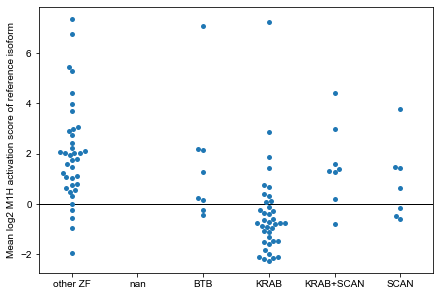

In [6]:
# categories
m1h['cat'] = np.nan
m1h.loc[m1h['is_ZF_reference_iso'] & m1h['is_KRAB'] & ~m1h['is_SCAN'], 'cat'] = 'KRAB'
m1h.loc[m1h['is_ZF_reference_iso'] & ~m1h['is_KRAB'] & m1h['is_SCAN'], 'cat'] = 'SCAN'
m1h.loc[m1h['is_ZF_reference_iso'] & m1h['is_KRAB'] & m1h['is_SCAN'], 'cat'] = 'KRAB+SCAN'
m1h.loc[m1h['is_ZF_reference_iso'] & m1h['is_BTB'], 'cat'] = 'BTB'
m1h.loc[m1h['is_ZF_reference_iso'] & ~m1h['is_KRAB'] & ~m1h['is_SCAN'] & ~m1h['is_BTB'], 'cat'] = 'other ZF'

fig, ax = plt.subplots(1, 1)
sns.swarmplot(data=m1h, x='cat', y='M1H_mean', ax=ax)
ax.set_ylabel('Mean log2 M1H activation score of reference isoform')
ax.set_xlabel('')
ax.axhline(y=0, color='black', linewidth=1)
fig.savefig('../figures/ZF-activation-ref-iso_split-by-other-domain_dotplot.pdf', bbox_inches='tight')

In [7]:
m1h.loc[m1h['is_ZF_reference_iso'] & ~m1h['is_KRAB'] & ~m1h['is_SCAN'], :].sort_values('M1H_mean').head(1)

,gene,clone_acc,M1H_rep1,M1H_rep2,M1H_rep3,M1H_mean,is_ZF,is_ZF_reference_iso,is_KRAB,is_SCAN,is_BTB,cat
155,OSR2,OSR2|1/2|09C08,-1.865847,-1.814835,-2.161196,-1.947293,True,True,False,False,False,other ZF


In [8]:
m1h.loc[m1h['is_ZF_reference_iso'] & m1h['is_KRAB'] & ~m1h['is_SCAN'], :].sort_values('M1H_mean', ascending=False).head(1)

,gene,clone_acc,M1H_rep1,M1H_rep2,M1H_rep3,M1H_mean,is_ZF,is_ZF_reference_iso,is_KRAB,is_SCAN,is_BTB,cat
330,ZNF473,ZNF473|1/2|10F12,7.125469,7.340258,7.204824,7.223517,True,True,True,False,False,KRAB


In [9]:
m1h.loc[m1h['is_ZF_reference_iso'] & ~m1h['is_KRAB'] & ~m1h['is_SCAN'], :].sort_values('M1H_mean', ascending=False).head(3)

,gene,clone_acc,M1H_rep1,M1H_rep2,M1H_rep3,M1H_mean,is_ZF,is_ZF_reference_iso,is_KRAB,is_SCAN,is_BTB,cat
525,ZFY,ZFY|1/2|06H10,7.331782,7.340753,7.360824,7.344453,True,True,False,False,False,other ZF
531,ZNF131,ZNF131|2/5|02A07,7.205926,7.129355,6.837645,7.057642,True,True,False,False,True,BTB
288,ZNF143,ZNF143|1/3|09D07,6.878875,6.800889,6.597953,6.759239,True,True,False,False,False,other ZF


In [11]:
pfam_to_clan = load_pfam_clans()
clan_to_pfam = {clan: {p for p, c in pfam_to_clan.items() if c == clan} for clan in set(pfam_to_clan.values())}

In [12]:
def count_c2h2_zf_in_ref_iso(gene):
    C2H2_ZF_PFAM_CLAN_ID = 'CL0361'
    c2h2_zf_pfam_accessions = clan_to_pfam[C2H2_ZF_PFAM_CLAN_ID]
    doubles = {'PF12756',  # C2H2 type zinc-finger (2 copies)
               'PF13465',  # Zinc-finger double domain
    }
    count = 0
    for dom in gene.reference_isoform.aa_seq_features:
        if dom.category == 'ZF_array':
            count += int(dom.name.split('_')[-1])
        elif dom.category == 'Pfam_domain':
            # todo double count for double ZF
            if dom.accession in c2h2_zf_pfam_accessions:
                if dom.accession in doubles:
                    count += 2
                else:
                    count += 1
    return count

n_zf_ref_iso = {gene_name: count_c2h2_zf_in_ref_iso(gene) for gene_name, gene in zfs.items()}

In [13]:
print(min(n_zf_ref_iso.values()), max(n_zf_ref_iso.values()))

0 21


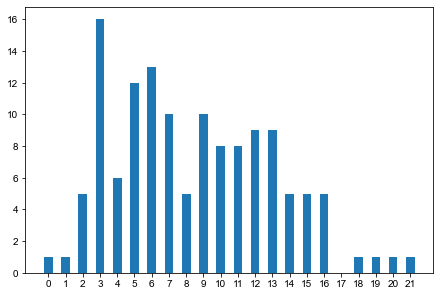

In [14]:
# is MANE select?
# color by KRAB etc.
fig, ax = plt.subplots(1, 1)
x_max = max(n_zf_ref_iso.values())
ax.hist(n_zf_ref_iso.values(),
        bins= x_max * 2 + 1,
        range=(-0.25, x_max + 0.25))
ax.set_xticks(range(0, x_max + 1));

In [15]:
# redo with table
# color by KRAB etc
# restrict to MANE select

In [16]:
df = pd.DataFrame(data=[(zf.name, 
                    zf.cloned_reference_isoform.name,
                    iso.name,
                    len([iso for iso in zf.isoforms if not (hasattr(iso, 'is_novel_isoform') and  iso.is_novel_isoform())]),
                    len(zf.cloned_isoforms),
                    len([iso for iso in zf.cloned_isoforms if iso.is_novel_isoform()]),
                    zf.cloned_MANE_select_isoform,
                    has_KRAB(zf),
                    has_SCAN(zf),
                    has_BTB(zf)
                    ) 
                    for zf in zfs.values()
                    for iso in zf.cloned_isoforms
                    if iso != zf.cloned_reference_isoform],
             columns=['gene',
                     'ref_iso',
                     'alt_iso',
                     'n_gencode_iso',
                     'n_cloned_iso',
                     'n_novel_iso',
                     'cloned_ref_is_MANE',
                     'is_KRAB',
                     'is_SCAN',
                     'is_BTB'])
df['cat'] = np.nan
df.loc[df['is_KRAB'] & ~df['is_SCAN'], 'cat'] = 'KRAB'
df.loc[~df['is_KRAB'] & df['is_SCAN'], 'cat'] = 'SCAN'
df.loc[df['is_KRAB'] & df['is_SCAN'], 'cat'] = 'KRAB+SCAN'
df.loc[df['is_BTB'], 'cat'] = 'BTB'
df.loc[~df['is_KRAB'] & ~df['is_SCAN'] & ~df['is_BTB'], 'cat'] = 'other ZF'

def count_c2h2_zf_in_iso(iso_name):
    C2H2_ZF_PFAM_CLAN_ID = 'CL0361'
    c2h2_zf_pfam_accessions = clan_to_pfam[C2H2_ZF_PFAM_CLAN_ID]
    doubles = {'PF12756',  # C2H2 type zinc-finger (2 copies)
               'PF13465',  # Zinc-finger double domain
    }
    count = 0
    for dom in zfs[iso_name.split('-')[0]][iso_name].aa_seq_features:
        if dom.category == 'ZF_array':
            count += int(dom.name.split('_')[-1])
        elif dom.category == 'Pfam_domain':
            # todo double count for double ZF
            if dom.accession in c2h2_zf_pfam_accessions:
                if dom.accession in doubles:
                    count += 2
                else:
                    count += 1
    return count

df['n_ZF_ref'] = df['ref_iso'].apply(count_c2h2_zf_in_iso)
df['n_ZF_alt'] = df['alt_iso'].apply(count_c2h2_zf_in_iso)

In [17]:
from data_loading import load_annotated_gencode_tfs

tfs_all = load_annotated_gencode_tfs()
zfs_all = {name: gene for name, gene in tfs_all.items() if gene.tf_family == 'C2H2 ZF'}
df_all = pd.DataFrame(data=[(zf.name, 
                    zf.reference_isoform.name,
                    iso.name,
                    len([iso for iso in zf.isoforms if not (hasattr(iso, 'is_novel_isoform') and  iso.is_novel_isoform())]),
                    has_KRAB(zf),
                    has_SCAN(zf),
                    has_BTB(zf)
                    ) 
                    for zf in zfs_all.values()
                    for iso in zf.isoforms],
             columns=['gene',
                     'ref_iso',
                     'alt_iso',
                     'n_gencode_iso',
                     'is_KRAB',
                     'is_SCAN',
                     'is_BTB'])
df_all['cat'] = np.nan
df_all.loc[df_all['is_KRAB'] & ~df_all['is_SCAN'], 'cat'] = 'KRAB'
df_all.loc[~df_all['is_KRAB'] & df_all['is_SCAN'], 'cat'] = 'SCAN'
df_all.loc[df_all['is_KRAB'] & df_all['is_SCAN'], 'cat'] = 'KRAB+SCAN'
df_all.loc[df_all['is_BTB'], 'cat'] = 'BTB'
df_all.loc[~df_all['is_KRAB'] & ~df_all['is_SCAN'] & ~df_all['is_BTB'], 'cat'] = 'other ZF'

reading from cache


In [18]:
# add PDI, PPI, m1h data
df.head()

,gene,ref_iso,alt_iso,n_gencode_iso,n_cloned_iso,n_novel_iso,cloned_ref_is_MANE,is_KRAB,is_SCAN,is_BTB,cat,n_ZF_ref,n_ZF_alt
0,ZBTB18,ZBTB18-1,ZBTB18-2,2,2,0,True,False,False,True,BTB,4,4
1,ZNF691,ZNF691-1,ZNF691-2,3,2,0,True,False,False,False,other ZF,7,7
2,ZBTB7B,ZBTB7B-2,ZBTB7B-1,2,2,0,True,False,False,True,BTB,3,3
3,PRDM16,PRDM16-1,PRDM16-2,4,2,2,False,False,False,False,other ZF,10,10
4,ZNF124,ZNF124-1,ZNF124-3,4,4,1,True,True,False,False,KRAB,11,7


In [19]:
# remove pairs with no data
print(df.shape[0], 'cloned reference / alternative isoforms')
print(df['cloned_ref_is_MANE'].sum(), 'of which have MANE select isoform cloned')

133 cloned reference / alternative isoforms
73 of which have MANE select isoform cloned


In [20]:
df.loc[df['cloned_ref_is_MANE'].isnull()]

,gene,ref_iso,alt_iso,n_gencode_iso,n_cloned_iso,n_novel_iso,cloned_ref_is_MANE,is_KRAB,is_SCAN,is_BTB,cat,n_ZF_ref,n_ZF_alt
19,ZNF131,ZNF131-2,ZNF131-5,3,4,1,None,False,False,True,BTB,6,0
28,PLAGL1,PLAGL1-1,PLAGL1-2,3,2,0,None,False,False,False,other ZF,6,0
45,ZNF438,ZNF438-1,ZNF438-2,4,2,0,None,False,False,False,other ZF,3,3
61,ZBTB1,ZBTB1-1,ZBTB1-2,2,2,1,None,False,False,True,BTB,7,0
78,ZNF75A,ZNF75A-1,ZNF75A-2,2,2,0,None,True,False,False,KRAB,5,0
80,ZNF747,ZNF747-1,ZNF747-2,3,3,0,None,True,False,False,KRAB,3,0
81,ZNF747,ZNF747-1,ZNF747-3,3,3,0,None,True,False,False,KRAB,3,0
95,ZNF177,ZNF177-1,ZNF177-2,4,3,1,None,True,False,False,KRAB,7,0
96,ZNF177,ZNF177-1,ZNF177-3,4,3,1,None,True,False,False,KRAB,7,0
97,ZNF544,ZNF544-1,ZNF544-5,7,6,3,None,True,False,False,KRAB,15,0


<AxesSubplot: xlabel='n_ZF_ref', ylabel='n_ZF_alt'>

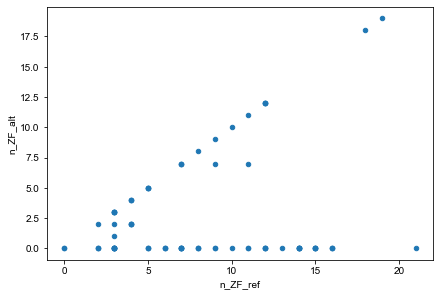

In [21]:
# size of circle
# make square
df.loc[(df['cloned_ref_is_MANE'] == True) | df['cloned_ref_is_MANE'].isnull()].plot.scatter(x='n_ZF_ref', y='n_ZF_alt')

In [22]:
n_zf_max = df['n_ZF_ref'].max()

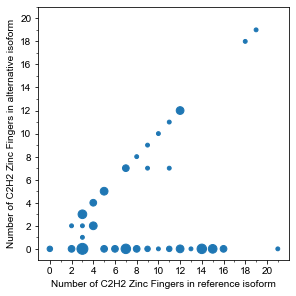

In [23]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
scaling = 15
((df.loc[(df['cloned_ref_is_MANE'] == True) | df['cloned_ref_is_MANE'].isnull()]
.groupby(['n_ZF_ref', 'n_ZF_alt'])
.size()
* scaling)
.rename('count')
.reset_index()
.plot.scatter(x='n_ZF_ref', y='n_ZF_alt', s='count', ax=ax))
ax.set_xticks(range(0, n_zf_max + 1, 2))
ax.set_yticks(range(0, n_zf_max + 1, 2))
ax.set_xticks(range(0, n_zf_max + 1), minor=True)
ax.set_yticks(range(0, n_zf_max + 1), minor=True)
ax.set_xlabel('Number of C2H2 Zinc Fingers in reference isoform')
ax.set_ylabel('Number of C2H2 Zinc Fingers in alternative isoform')
fig.savefig('../figures/n-ZF_ref-vs-alt_scatter.pdf',
            bbox_inches='tight')

In [24]:
# summary numbers
# inspect those with partial loss of ZFs
cloned_ref = ((df['cloned_ref_is_MANE'] == True) | df['cloned_ref_is_MANE'].isnull())
df.loc[cloned_ref &
       (df['n_ZF_alt'] < df['n_ZF_ref']) &
       (df['n_ZF_alt'] >= 1),
:]

,gene,ref_iso,alt_iso,n_gencode_iso,n_cloned_iso,n_novel_iso,cloned_ref_is_MANE,is_KRAB,is_SCAN,is_BTB,cat,n_ZF_ref,n_ZF_alt
4,ZNF124,ZNF124-1,ZNF124-3,4,4,1,True,True,False,False,KRAB,11,7
14,KLF7,KLF7-1,KLF7-8,5,7,3,True,False,False,False,other ZF,3,2
49,ZBTB44,ZBTB44-1,ZBTB44-3,4,6,4,True,False,False,True,BTB,4,2
50,ZBTB44,ZBTB44-1,ZBTB44-4,4,6,4,True,False,False,True,BTB,4,2
51,ZBTB44,ZBTB44-1,ZBTB44-5,4,6,4,True,False,False,True,BTB,4,2
52,ZBTB44,ZBTB44-1,ZBTB44-6,4,6,4,True,False,False,True,BTB,4,2
58,KLF12,KLF12-2,KLF12-1,1,2,1,True,False,False,False,other ZF,3,1
68,CTCF,CTCF-1,CTCF-2,3,2,0,True,False,False,False,other ZF,9,7


In [25]:
df.loc[cloned_ref &
       (df['n_ZF_alt'] < df['n_ZF_ref']) &
       (df['n_ZF_alt'] >= 1),
:].shape[0]

8

In [26]:
df.loc[cloned_ref &
       (df['n_ZF_alt'] == df['n_ZF_ref']),
:].shape[0]

28

In [27]:
df.loc[cloned_ref &
       (df['n_ZF_alt'] == 0),
:].shape[0]

53

In [28]:
df.loc[df['n_ZF_alt'] > df['n_ZF_ref'], :]

,gene,ref_iso,alt_iso,n_gencode_iso,n_cloned_iso,n_novel_iso,cloned_ref_is_MANE,is_KRAB,is_SCAN,is_BTB,cat,n_ZF_ref,n_ZF_alt
22,ZNF451,ZNF451-2,ZNF451-3,6,7,5,False,False,False,False,other ZF,0,2
23,ZNF451,ZNF451-2,ZNF451-4,6,7,5,False,False,False,False,other ZF,0,2
65,ZNF280D,ZNF280D-2,ZNF280D-1,3,2,1,False,False,False,False,other ZF,0,3
88,ZNF397,ZNF397-2,ZNF397-1,5,5,1,False,False,True,False,SCAN,0,9
115,ZNF180,ZNF180-2,ZNF180-1,5,3,1,False,True,False,False,KRAB,0,13


In [29]:
# inspect those with 0, 1...
df.loc[df['cloned_ref_is_MANE'] == True, :].sort_values('n_ZF_ref').head()

,gene,ref_iso,alt_iso,n_gencode_iso,n_cloned_iso,n_novel_iso,cloned_ref_is_MANE,is_KRAB,is_SCAN,is_BTB,cat,n_ZF_ref,n_ZF_alt
87,ZNF207,ZNF207-1,ZNF207-3,5,4,1,True,False,False,False,other ZF,0,0
86,ZNF207,ZNF207-1,ZNF207-2,5,4,1,True,False,False,False,other ZF,0,0
84,ZNF688,ZNF688-2,ZNF688-5,4,3,1,True,True,False,False,KRAB,2,0
63,ZBTB25,ZBTB25-1,ZBTB25-2,3,3,0,True,False,False,True,BTB,2,0
64,ZBTB25,ZBTB25-1,ZBTB25-4,3,3,0,True,False,False,True,BTB,2,0


In [30]:
pairs = load_ref_vs_alt_isoforms_table()

In [31]:
pairs.head()

,gene_symbol,Ensembl_gene_ID,family,is_dimerizing_TF_family,clone_acc_ref,clone_acc_alt,Ensembl_transcript_IDs_ref,Ensembl_transcript_IDs_alt,is_ref_novel_isoform,is_alt_novel_isoform,is_MANE_select_isoform_cloned,n_aa_ref,n_aa_alt,n_exons_ref,n_exons_alt,is_alternative_N_terminal,is_alternative_C_terminal,is_alternative_internal_exon,is_alternative_5_prime_donor,is_alternative_3_prime_acceptor,is_exon_skipping,is_mutually_exclusive_exons,is_intron_retention,dbd_insertion_n_aa,dbd_pct_lost,dbd_affected,aa_seq_pct_id,n_positive_PPI_ref,n_positive_PPI_alt,n_PPI_successfully_tested_in_ref_and_alt,n_positive_PPI_ref_filtered,n_positive_PPI_alt_filtered,n_shared_PPI,PPI_jaccard,dimer_ppi,other_than_dimer_ppi,tf_tf_ppi,tf_cofactor_ppi,tf_signalling_ppi,n_positive_PDI_ref,n_positive_PDI_alt,n_PDI_successfully_tested_in_ref_and_alt,n_positive_PDI_ref_filtered,n_positive_PDI_alt_filtered,n_shared_PDI,PDI_jaccard,at_least_one_isoform_in_gene_abs_activation_gte_2fold,activation_ref,activation_alt,activation_fold_change_log2
0,ZBTB18,ENSG00000179456,C2H2 ZF,False,ZBTB18|1/2|04E08,ZBTB18|2/2|12E05,ENST00000358704,ENST00000622512,False,False,True,531,522,2,1,True,False,False,False,True,False,False,False,0.0,0.000000,False,98.1,4.0,3.0,4.0,4.0,3.0,3.0,0.75,NaN,loses some,loses some,retains all,retains all,0.0,1.0,1.0,0.0,1.0,0.0,0.000000,True,2.153413,2.656826,0.503414
1,PRRX1,ENSG00000116132,Homeodomain,False,PRRX1|2/3|09F06,PRRX1|1/3|09C07,ENST00000239461,ENST00000367760,False,False,True,245,217,4,4,False,True,False,False,False,False,False,False,0.0,0.000000,False,82.0,0.0,13.0,13.0,0.0,13.0,0.0,0.00,NaN,NaN,NaN,NaN,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN,True,1.552087,0.679816,-0.872271
2,PRRX1,ENSG00000116132,Homeodomain,False,PRRX1|2/3|09F06,PRRX1|3/3|09H08,ENST00000239461,ENST00000497230,False,False,True,245,200,4,3,False,True,False,True,False,False,False,False,0.0,0.000000,False,81.2,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,13.0,14.0,14.0,13.0,13.0,0.928571,True,1.552087,0.773129,-0.778958
3,POU2F1,ENSG00000143190,Homeodomain; POU,False,POU2F1|2/2|04D01,POU2F1|1/2|03F12,ENST00000541643,ENST00000367862,False,False,False,743,755,15,16,True,False,False,False,True,False,False,False,0.0,0.000000,False,98.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,2.509024,NaN,NaN
4,ATF3,ENSG00000162772,bZIP,True,ATF3|1/2|08B04,ATF3|2/2|08D04,ENST00000341491|ENST00000366987,ENST00000366983,False,False,True,181,135,3,3,False,True,False,False,False,False,False,False,19.0,46.774194,True,65.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0.979226,-0.381163,-1.360389


In [32]:
clone_name_to_acc = {iso.name: iso.clone_acc for zf in zfs.values() for iso in zf.cloned_isoforms}
df['clone_acc_ref'] = df['ref_iso'].map(clone_name_to_acc)
df['clone_acc_alt'] = df['alt_iso'].map(clone_name_to_acc)

In [33]:
df = pd.merge(df, pairs, how='left', on=['clone_acc_ref', 'clone_acc_alt'])

In [34]:
# subset
df.loc[(df['PDI_jaccard'] < 1) & (df['PDI_jaccard'] > 0)]

,gene,ref_iso,alt_iso,n_gencode_iso,n_cloned_iso,n_novel_iso,cloned_ref_is_MANE,is_KRAB,is_SCAN,is_BTB,cat,n_ZF_ref,n_ZF_alt,clone_acc_ref,clone_acc_alt,gene_symbol,Ensembl_gene_ID,family,is_dimerizing_TF_family,Ensembl_transcript_IDs_ref,Ensembl_transcript_IDs_alt,is_ref_novel_isoform,is_alt_novel_isoform,is_MANE_select_isoform_cloned,n_aa_ref,n_aa_alt,n_exons_ref,n_exons_alt,is_alternative_N_terminal,is_alternative_C_terminal,is_alternative_internal_exon,is_alternative_5_prime_donor,is_alternative_3_prime_acceptor,is_exon_skipping,is_mutually_exclusive_exons,is_intron_retention,dbd_insertion_n_aa,dbd_pct_lost,dbd_affected,aa_seq_pct_id,n_positive_PPI_ref,n_positive_PPI_alt,n_PPI_successfully_tested_in_ref_and_alt,n_positive_PPI_ref_filtered,n_positive_PPI_alt_filtered,n_shared_PPI,PPI_jaccard,dimer_ppi,other_than_dimer_ppi,tf_tf_ppi,tf_cofactor_ppi,tf_signalling_ppi,n_positive_PDI_ref,n_positive_PDI_alt,n_PDI_successfully_tested_in_ref_and_alt,n_positive_PDI_ref_filtered,n_positive_PDI_alt_filtered,n_shared_PDI,PDI_jaccard,at_least_one_isoform_in_gene_abs_activation_gte_2fold,activation_ref,activation_alt,activation_fold_change_log2
130,ZIC3,ZIC3-2,ZIC3-1,2,3,2,True,False,False,False,other ZF,5,5,ZIC3|2/3|12F04,ZIC3|1/3|09F05,ZIC3,ENSG00000156925,C2H2 ZF,False,ENST00000287538,NaN,False,True,True,467,410,3,4,False,True,False,True,True,False,False,True,0.0,1.197605,True,87.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,13.0,17.0,17.0,13.0,13.0,0.764706,True,2.912431,2.703920,-0.208512
131,ZIC3,ZIC3-2,ZIC3-3,2,3,2,True,False,False,False,other ZF,5,5,ZIC3|2/3|12F04,ZIC3|3/3|09C04,ZIC3,ENSG00000156925,C2H2 ZF,False,ENST00000287538,NaN,False,True,True,467,456,3,4,False,True,False,True,True,False,False,True,0.0,1.197605,True,88.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,13.0,17.0,17.0,13.0,13.0,0.764706,True,2.912431,1.442217,-1.470214


In [35]:
# add PDI data
# for those with the same number of ZFs, is the spacing changed?
# check for insertions within arrays or for sequence changes **between** mutliple arrays?
# BUT this would only be interesting for those with PDIs, right?
y1h = load_y1h_pdi_data()

In [36]:
# TODO FIX!!!
y1h['unique_acc'].duplicated().sum()

2

In [37]:
df['pdi_n_bait_ref'] = df['clone_acc_ref'].map(y1h.drop_duplicates(subset=['unique_acc']).drop(columns=['tf']).set_index('unique_acc').sum(axis=1))
df['pdi_n_bait_alt'] = df['clone_acc_alt'].map(y1h.drop_duplicates(subset=['unique_acc']).drop(columns=['tf']).set_index('unique_acc').sum(axis=1))

In [38]:
df.loc[(df['PDI_jaccard'] == 0) & (df['pdi_n_bait_ref'] > 0) & (df['pdi_n_bait_alt'] > 0)]

,gene,ref_iso,alt_iso,n_gencode_iso,n_cloned_iso,n_novel_iso,cloned_ref_is_MANE,is_KRAB,is_SCAN,is_BTB,cat,n_ZF_ref,n_ZF_alt,clone_acc_ref,clone_acc_alt,gene_symbol,Ensembl_gene_ID,family,is_dimerizing_TF_family,Ensembl_transcript_IDs_ref,Ensembl_transcript_IDs_alt,is_ref_novel_isoform,is_alt_novel_isoform,is_MANE_select_isoform_cloned,n_aa_ref,n_aa_alt,n_exons_ref,n_exons_alt,is_alternative_N_terminal,is_alternative_C_terminal,is_alternative_internal_exon,is_alternative_5_prime_donor,is_alternative_3_prime_acceptor,is_exon_skipping,is_mutually_exclusive_exons,is_intron_retention,dbd_insertion_n_aa,dbd_pct_lost,dbd_affected,aa_seq_pct_id,n_positive_PPI_ref,n_positive_PPI_alt,n_PPI_successfully_tested_in_ref_and_alt,n_positive_PPI_ref_filtered,n_positive_PPI_alt_filtered,n_shared_PPI,PPI_jaccard,dimer_ppi,other_than_dimer_ppi,tf_tf_ppi,tf_cofactor_ppi,tf_signalling_ppi,n_positive_PDI_ref,n_positive_PDI_alt,n_PDI_successfully_tested_in_ref_and_alt,n_positive_PDI_ref_filtered,n_positive_PDI_alt_filtered,n_shared_PDI,PDI_jaccard,at_least_one_isoform_in_gene_abs_activation_gte_2fold,activation_ref,activation_alt,activation_fold_change_log2,pdi_n_bait_ref,pdi_n_bait_alt


In [39]:
# jaccard is 0 but both have some
y1h.sum(axis=1)

<ipython-input-39-6395cb1d28de>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  y1h.sum(axis=1)


162    0.0
0      3.0
1      9.0
174    0.0
2      3.0
      ... 
135    1.0
136    1.0
166    0.0
137    4.0
138    1.0
Length: 197, dtype: float64

In [40]:
y1h.head()
# n_baits_ref, n_baits_alt, jaccard


,tf,unique_acc,HS1022,HS1043,HS1067,HS1139,HS1142,HS118,HS1181,HS1185,HS1199,HS1208,HS1242,HS1271,HS129,HS1315,HS1329,HS1339,HS135,HS1419,HS1436,HS1480,HS149,HS151,HS1516,HS1551,HS1597,HS162,HS1657,HS169,HS170,HS1707,HS174,HS181,HS1811,HS1833,HS1867,HS189,HS194,HS20,HS204,HS2048,HS205,HS2062,HS2081,HS213,HS215,HS218,HS238,HS240,...,MUT_32,MUT_36,MUT_37,MUT_40,MUT_41,MUT_46,MUT_64,MUT_75,CCL14,CCL15,CCL20,CCL24,CCL28,CCL3L1,CCL4,CCL5,CCL8,CSF1,CXCL10,CXCL17,CXCL2,CXCL3,CXCL5,IFNK,IFNL1,IFNL4,IL10,IL12A,IL17A,IL17F,IL21,IL25,IL26,IL3,IL31,IL32,IL33,IL34,IL36A,IL37,KITLG,LTA,PF4V1,TNFSF10,TNFSF13,TNFSF14,TNFSF4,TNFSF8,XCL1,XCL2
162,CREB1,CREB1|1/2|02E01,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
0,CREB1,CREB1|2/2|01F12,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,DLX1,DLX1|1/2|07A12,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
174,DLX1,DLX1|2/2|07E09,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,DLX4,DLX4|1/3|11A04,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [41]:
from data_loading import load_y2h_isoform_data

y2h = load_y2h_isoform_data(require_at_least_one_ppi_per_isoform=False)
y2h = y2h.loc[y2h['ad_gene_symbol'].isin(zfs_all.keys()), :]
y2h['cat'] = y2h['ad_gene_symbol'].map(df_all.drop_duplicates('gene').set_index('gene')['cat'])

In [42]:
df['cat'].value_counts()

other ZF     52
KRAB         50
BTB          13
SCAN         10
KRAB+SCAN     8
Name: cat, dtype: int64

In [43]:
zfzf = y2h.loc[y2h['db_gene_symbol'].isin(zfs_all.keys())].copy()
zfzf['ad_zf_cat'] = zfzf['ad_gene_symbol'].map(df_all.drop_duplicates('gene').set_index('gene')['cat'])
zfzf['db_zf_cat'] = zfzf['db_gene_symbol'].map(df_all.drop_duplicates('gene').set_index('gene')['cat'])

<ipython-input-44-7ee8fbbb7052>:27: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  plt.savefig('../figures/ZF_ZF_correlogram.pdf', bbox_inches='tight')
/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


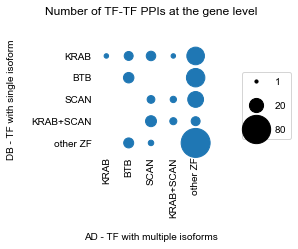

In [44]:
zf_cats = ['KRAB', 'BTB', 'SCAN', 'KRAB+SCAN', 'other ZF']

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(2, 2)
scaling = 10
sc = ax.scatter(x=[x for x in zf_cats for y in zf_cats],
           y=[y for x in zf_cats for y in zf_cats],
           s=[((zfzf['ad_zf_cat'] == x) & (zfzf['db_zf_cat'] == y)).sum() * scaling for x in zf_cats for y in zf_cats],
           clip_on=False)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0, rotation=90)
for s in ax.spines.values():
    s.set_visible(False)
ax.set_xlim(-0.5, len(zf_cats) - 0.5)
ax.set_ylim(len(zf_cats) - 0.5, -0.5)
ax.set_xlabel('AD - TF with multiple isoforms',
              labelpad=15)
ax.set_ylabel('DB - TF with single isoform',
              labelpad=15)
ax.set_title('Number of TF-TF PPIs at the gene level',
             pad=30)
ax.legend(*sc.legend_elements('sizes',
                              num=[1, 20, 80],
                              func=lambda x: x / scaling),
          bbox_to_anchor=[1.8, 0.8],
         labelspacing=1.3)
plt.savefig('../figures/ZF_ZF_correlogram.pdf', bbox_inches='tight')

In [45]:
# rewiring by AS of these different PPIs